<a href="https://colab.research.google.com/github/sugiyama404/acrobot/blob/main/Acrobot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x
!apt install swig cmake libopenmpi-dev zlib1g-dev
!pip install stable-baselines[mpi]==2.8.0
!apt-get install -y xvfb python-opengl ffmpeg

TensorFlow 1.x selected.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2).
libopenmpi-dev is already the newest version (2.1.1-8).
swig is already the newest version (3.0.12-1).
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
xvfb is already the newest version (2:1.19.6-1ubuntu4.9).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [2]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
import tensorflow as tf
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)
import logging
tf.get_logger().setLevel(logging.ERROR)

In [3]:
import time
import numpy as np
import matplotlib.pyplot as plt

import gym

from stable_baselines.deepq.policies import MlpPolicy, CnnPolicy, LnCnnPolicy
from stable_baselines.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines.common import set_global_seeds
from stable_baselines import DQN

from stable_baselines.common.vec_env import VecVideoRecorder


from IPython import display as ipythondisplay
from IPython.display import HTML

import warnings
warnings.filterwarnings("ignore")

import io
import glob
import base64

import re

In [4]:
env_id='Acrobot-v1'
cell=['MlpPolicy', 'CnnPolicy', 'LnCnnPolicy']
policies=cell[0]
ave_csv = cell[0] + '_average.csv'
win_csv = cell[0] + '_win.csv'
csv_files = [ave_csv,win_csv]
env_vec = DummyVecEnv([lambda: gym.make(env_id)])

In [5]:
def evaluate(env, model, n_step=10000, n_ave=100):

    states = env.reset()
    true_num = 0
    ave_num = 0

    for i in range(n_step):
        action, _h = model.predict(states)
        states, rewards, dones, info = env.step(action)

        if dones[0]:  # エピソード終了時(もし成功した時)
            # videoを止めるための処理、初期化する処理
            states = env.reset()
            true_num += 1
            ave_num += 1

        if re.match('^[0-9]000+$', str(i)):
            print('ave_num = ' + str(ave_num))
            with open(ave_csv, 'a') as f:
                print(str(ave_num), file=f)
            ave_num = 0
    
    print('取得報酬 =' + str(true_num))
    with open(win_csv, 'a') as f:
        print(str(true_num), file=f)

In [6]:
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

def show_video(video_dir):
    video_list = glob.glob(video_dir+"/*.mp4")
    if len(video_list) > 0:
        # 一番最初に撮った画像を出力しているだけ。すでに保存がされている。
        # 一番うまくいっているものを抽出して、別フォルダーに写かえる処理が必要。
        mp4 = video_list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                    </video>'''.format(encoded.decode('ascii'))))

In [7]:
import shutil

train_cnt = [0,100000]

dir_f = ['negative_control_videos/','traning_videos/']

for item in dir_f:
    file_exit=os.path.exists(item)
    if file_exit:
        shutil.rmtree(item)
        print(item + " ディレクトリーの削除に成功しました。")

for item in csv_files:
    csv_exit=os.path.isfile(item)
    if csv_exit:
        os.remove(item)
        print(item + " ファイルの削除に成功しました。")

for item in train_cnt:
    model = DQN(policies, env_vec, verbose=0)  # モデルの初期化
    folder_name = 'negative_control_videos/'
    if item != 0:
        # トレーニング環境を使ってSACをトレーニング
        model.learn(total_timesteps=item)  # モデルの訓練
        model.save("Acrobot" + item)  # モデルの保存
        folder_name = 'traning_videos/'


    env = VecVideoRecorder(env_vec, video_folder=folder_name,  # 動画記録の設定
                                record_video_trigger=lambda step: step == 0, video_length=1000,
                                name_prefix="tran")

    evaluate(env, model, n_step=10000, n_ave=100)

MlpPolicy_average.csv ファイルの削除に成功しました。
ave_num = 2
ave_num = 2
ave_num = 2
ave_num = 2
ave_num = 2
ave_num = 2
ave_num = 2
ave_num = 2
ave_num = 2
取得報酬 =20
ave_num = 11
ave_num = 13
ave_num = 12
ave_num = 9
ave_num = 12
ave_num = 12
ave_num = 12
ave_num = 12
ave_num = 12
取得報酬 =116


In [8]:
show_video("negative_control_videos")

In [9]:
show_video("traning_videos")

In [22]:
dir_f = ['negative_control_videos/','traning_videos/']
new_name = ['first.mp4','second.mp4']

folder_exit=os.path.exists('tmp/')
if folder_exit:
    shutil.rmtree('tmp/')
    print('tmp/ディレクトリーの削除に成功しました。')

os.mkdir('tmp')

for index, item in enumerate(dir_f):
    video_list = glob.glob(item+"/*.mp4")
    if len(video_list) > 0:
        mp4 = video_list[0]
        shutil.move(mp4, 'tmp/'+new_name[index])



tmp/ディレクトリーの削除に成功しました。


In [28]:
import imageio
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# 動画をアニメに変換
def video_anime(video):
    video = imageio.mimread(video,memtest=False)   # フレームにばらす
    fig = plt.figure(figsize=(5,5))  # 表示サイズ指定

    mov = []
    for i in range(len(video)):  # フレームを1枚づつmovにアペンド
        img = plt.imshow(video[i], animated=True)
        plt.axis('off')
        mov.append([img])

    # アニメーション作成        
    anime = animation.ArtistAnimation(fig, mov, interval=50, repeat_delay=1000)
    plt.close()
    return anime

# HTML5でアニメをインラインに動画表示 
HTML(video_anime('tmp/first.mp4').to_html5_video())  

In [48]:
import cv2
from google.colab.patches import cv2_imshow

from PIL import Image
import glob


new_name = ['first','second']

folder_exit=os.path.exists('dist/')
if folder_exit:
    shutil.rmtree('dist/')
    print('dist/ディレクトリーの削除に成功しました。')

os.mkdir('dist')

i = 0

for item in new_name:

    cap = cv2.VideoCapture('tmp/' + item + '.mp4')

    while(True):
        i +=1

        ret, frame = cap.read()
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(frame, item , (20, 50), font, 1,
                    (255, 0, 0), 1, cv2.LINE_4)
    
        # Display the resulting frame
        if frame is None:
            break
        
        dst_file = "dist/{index:04d}.jpg".format(index=i)
        cv2.imwrite(dst_file, frame)
        #cv2_imshow(frame)
    
        # creating 'q' as the quit 
        # button for the video
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    # release the cap object
    cap.release()
    # close all windows
    cv2.destroyAllWindows()


files = sorted(glob.glob('dist/*.jpg'))  
images = list(map(lambda file : Image.open(file) , files))
images[0].save('image.gif' , save_all = True , append_images = images[1:] , duration = 60 , loop = 0)

dist/ディレクトリーの削除に成功しました。


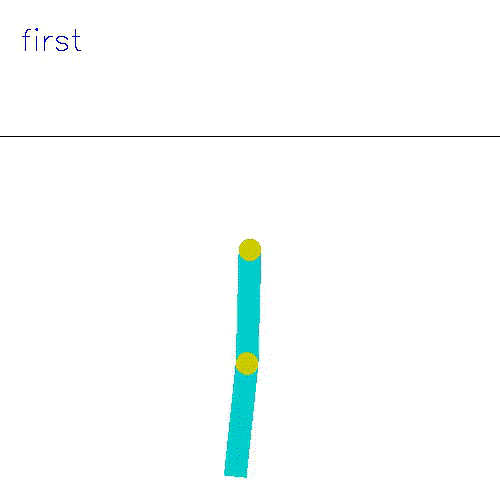

In [49]:
from IPython.display import Image as getImage

getImage('image.gif', format='jpg')